<div class="alert alert-info">

<H2> Predictive modeling </H2>

<p>
Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period , identify which factors predict future user
adoption.
</p>

    
<H3> takehome_user_engagement </H3>

Data Features:
    <ol>
        <li>has a row for each day that a user logged into the product.</li>
    </ol>

<H3> takehome_users </H3>

Data Features:
    <ol>
        <li>name: the user's name</li>
        <li>object_id: the user's id </li>
        <li>email: email address </li>
        <li>creation_source: how their account was created. 
            This takes on one of 5 values; 1. PERSONAL_PROJECTS: invited to join another user's personal workspace, 2. GUEST_INVITE: invited to an organization as a guest
(limited permissions), 3. ORG_INVITE: invited to an organization (as a full member), 4. SIGNUP: signed up via the website, and 5. SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id) </li>
        <li>creation_time: when they created their account </li>
        <li>last_session_creation_time: unix timestamp of last login </li>
        <li>opted_in_to_mailing_list: whether they have opted into receiving
marketing emails </li>
        <li>enabled_for_marketing_drip: whether they are on the regular
marketing email drip </li>
        <li>avg_surge: The average surge multiplier over all of this user’s trips </li>
        <li>org_id: the organization (group of users) they belong to </li>
        <li>invited_by_user_id: which user invited them to join (if applicable) </li>
     </ol>
 

<div class="alert alert-success">
<H3> Step 1. Cleaning, Exploratory Data Analysis, and/or Visualizations: </H3>
</div>

In [3]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# statistical processing
from sklearn import preprocessing

# imports for xgboost
from xgboost import XGBClassifier, cv, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# data viz imports
plt.style.use('tableau-colorblind10')
%matplotlib inline

In [4]:
# load data and assign to dataframe: df
df = pd.read_csv('data/takehome_users.csv', encoding = 'latin')

# load data and assign to dataframe: engagement
engagement = pd.read_csv('data/takehome_user_engagement.csv')

In [5]:
# examine columns
df.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id'],
      dtype='object')

In [6]:
# examine first five records of df
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [7]:
# look deeper to see completeness of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


<div class="alert alert-warning">
<strong>There are missing values for the 'last_session_creation_time' and 'invited_by_user_id'. There are no missing values in the engagement dataframe. It is also of note that the last_session_creation_time appears to be in the wrong format: float64, versus format: object/datetimevalue.</strong>
</div>

In [8]:
# get some basic statistics on numbered features
df[['opted_in_to_mailing_list', 'enabled_for_marketing_drip']].describe()

,opted_in_to_mailing_list,enabled_for_marketing_drip
count,12000.000000,12000.000000
mean,0.249500,0.149333
std,0.432742,0.356432
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


<div class="alert alert-warning">
<strong>Here we can see that a relative few amount of members opted for the mailing list (about 25%) or are enabled for maketing drip (15%).</strong>
</div>

In [9]:
# examine first five records of df
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [10]:
# look deeper to see completeness of the data
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


<div class="alert alert-success">
<H2> Step 2. The analysis approach </H2>
    
<p>
I will use the engagement data to identify users who have logged into the system at least 3 times in a seven day period. With those users ids, I will use the main dataframe to identify features that predict if the user will be active. Initial thoughts are that creation_source, org_id, mailing_list, market_drip, and perhaps if they were invited (not by whom, just if they were) could be good predictors.
</p>

In [11]:
# select only the users who three or more times: engage
engage = engagement.groupby('user_id').filter(lambda x: len(x) >= 3)

# reset index due to rows being removed in prior step that filtered out engagement less than 3
engage.reset_index(drop=True, inplace = True)

# examine first five records of df
engage.head()

,time_stamp,user_id,visited
0,2013-11-15 03:45:04,2,1
1,2013-11-29 03:45:04,2,1
2,2013-12-09 03:45:04,2,1
3,2013-12-25 03:45:04,2,1
4,2013-12-31 03:45:04,2,1


In [12]:
# this for loop runs through the dataframe, creates a week from a date, and then checks if the next two dates fall within that time.

# it then ouputs the user_id to a list (as we are looking for users who have consecutive logins).
active = 0
active_status = []
for i in range(len(engage)-2):
    user = engage['user_id'][i] #get current user_id
    if user != active and user == engage['user_id'][i+2]: #so we can skip a user that has already been active and to make sure we don't compare to the next user
        st = pd.Timestamp(engage['time_stamp'][i]) #get start date
        et = st + pd.Timedelta('7D') # make range for end date
        if st < pd.Timestamp(engage['time_stamp'][i+1]) < et and st < pd.Timestamp(engage['time_stamp'][i+2]) < et:
            active_status.append(user) # now that the active condition has been met, return that user
            active = user                  #define the user as active

In [13]:
# count active users
print('The resulting active status count is:', len(active_status))

The resulting active status count is: 1602


In [14]:
y = pd.Series(np.random.randn(len(df)))
n = 0
for i in range(len(df)):
    if df['object_id'][i] == active_status[n]:
        y[i] = 1
        n = n+1
        if n > len(active_status)-1:
            n = n -1
    else:
        y[i] = 0
y.head()

0    0.0
1    1.0
2    0.0
3    0.0
4    0.0
dtype: float64

In [15]:
# concatenate active_users to main dataframe to have data in one place
df1 = pd.DataFrame(y,columns = ['active_status'])
df = pd.concat([df,df1], axis = 1)

# examine first five records of engage
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_status
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0


In [16]:
# this for loop will turn the invited_by_user_id column into simple binary: 'was invited'=1 or 'not'=0
inv = pd.Series(np.random.randn(len(df)))
for i in range(len(df)):
    if df['invited_by_user_id'][i] >=1:
        inv[i] = 1
    else:
        inv[i] = 0
df2 = pd.DataFrame(inv, columns = ['invited'])
df = pd.concat([df,df2], axis = 1)
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_status,invited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0,1.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0,1.0


In [17]:
# curiously looking at  inv counts
inv.value_counts()

1.0    6417
0.0    5583
dtype: int64

<div class="alert alert-success">
<H2> Step 3. Predictive modeling </H2>
    
<p>
With the feature active users now identified we can now use this dependent variable to discover which independent variables influuence or predict the active users as a dependent variable.
</p>

In [18]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(['ORG_INVITE','GUEST_INVITE','PERSONAL_PROJECTS','SIGNUP','SIGNUP_GOOGLE_AUTH'])

LabelEncoder()

In [19]:
creation = le.transform(df['creation_source'])

In [20]:
df3 = pd.DataFrame(creation,columns = ['creation'])

In [21]:
df = pd.concat([df,df3],axis=1)
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_status,invited,creation
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0,1.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,1.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0,1.0,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0,1.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0,1.0,0


<div class="alert alert-success">
<H3>a. Split Data</H3>
</div>

In [22]:
# define features and target
X = df[['creation','last_session_creation_time','opted_in_to_mailing_list','enabled_for_marketing_drip','org_id']]
y = df['active_status']

# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=123)

In [23]:
# dictionary of parameters to optimize, and the range of optimization values
parameters = {
    'max_delta_step':[0,0.05],
    'scale_pos_weight':[0.95, 0.9],
    'subsample':[1,0.8],
    'learning_rate': [0.25, 0.2, 0.1],
    'min_child_weight':[0,1,2],
    'gamma':[1, 2, 3]
    }

<div class="alert alert-success">
<H3>b. Hyperparameter optimization</H3>
</div>

In [24]:
# instantiate classifier
xg_clf = XGBClassifier(objective = 'binary:logistic', random_state = 42, silent = 1, n_estimators=10, max_depth= 8)

# RandomSearch
grid_search = GridSearchCV(param_grid= parameters, estimator = xg_clf, cv=3, scoring='accuracy')
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=8, min_child_weight=1,
                                     missing=None, n_estimators=10, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=1,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'gamma': [1, 2, 3], 'learning_rate': [0.25, 0.2, 0.1],
                         'max_delta_step': [0, 0.05],
                         'min_child_

In [25]:
# Print best parameters and results
print(grid_search.best_params_)
print(grid_search.best_score_)

{'gamma': 3, 'learning_rate': 0.1, 'max_delta_step': 0, 'min_child_weight': 2, 'scale_pos_weight': 0.95, 'subsample': 0.8}
0.9228571428571428


<div class="alert alert-success">
<H3>c. Validate optimized parameters</H3>
</div>

In [26]:
# optimized parameters
optimized_parameters = {'objective':'binary:logistic',
                        'n_estimators': 10,
                        'random_state': 42,
                        'silent': 0,
                        'subsample': .8, 
                        'scale_pos_weight': 0.95, 
                        'min_child_weight': 2, 
                        'max_depth': 8, 
                        'max_delta_step': 0, 
                        'learning_rate': 0.1, 
                        'gamma': 3
                       }

In [27]:
# instantiate classifier
xg_clf_opt = XGBClassifier(**optimized_parameters)
xg_clf_opt.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=3,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=2, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.95, seed=None,
              silent=0, subsample=0.8, verbosity=1)

In [28]:
# predict the labels
y_opt_pred = xg_clf_opt.predict(X_train)

# score model
score = accuracy_score(y_train, y_opt_pred)

# print accuracy
print("The resulting accuracy of the optimized classifier is {}.".format(round(score,4)))

The resulting accuracy of the optimized classifier is 0.9352.


In [29]:
# train unoptimized model
xg_clf.fit(X_train, y_train)

# predict the labels of unoptimized model
y_unopt_pred = xg_clf.predict(X_train)

# score model
un_score = accuracy_score(y_train, y_unopt_pred)

# print accuracy
print("The resulting accuracy of the unoptimized classifier is {}.".format(round(un_score,4)))

The resulting accuracy of the unoptimized classifier is 0.9437.


<div class="alert alert-warning">
<strong>The optimization process did improve the model using the training data, so the next step is to see how it performs with the test set.</strong>
</div>

In [30]:
# predict the labels
y_opt_test = xg_clf_opt.predict(X_test)

# score model
test_score = accuracy_score(y_test, y_opt_test)

# print accuracy
print("The resulting accuracy of the optimized classifier for the test set is {}.".format(round(test_score,4)))

The resulting accuracy of the optimized classifier for the test set is 0.9178.


In [31]:
# predict the labels of unoptimized model using the test set
y_unopt_test = xg_clf.predict(X_train)

# score model
test_score = accuracy_score(y_train, y_unopt_test)

# print accuracy
print("The resulting accuracy of the unoptimized classifier is {}.".format(round(test_score,4)))

The resulting accuracy of the unoptimized classifier is 0.9437.


<div class="alert alert-warning">
<strong>The optimized model performs worse with the test set, which means it is overfitting. Therefore, I will train the final model with all of the data using the default values</strong>
</div>

In [32]:
# instantiate classifier
xg_clf_final = XGBClassifier(objective = 'binary:logistic', random_state = 42, silent = 1, n_estimators=200, max_depth= 8)

# train final model
xg_clf_final.fit(X, y)

# save model
pickle.dump(xg_clf_final, open('final_model.pickle', 'wb'))

<div class="alert alert-success">
<H2> Model Insights </H2>

<p>
Determine the most important features of the model, and discuss what this means for user adoption.
</p>

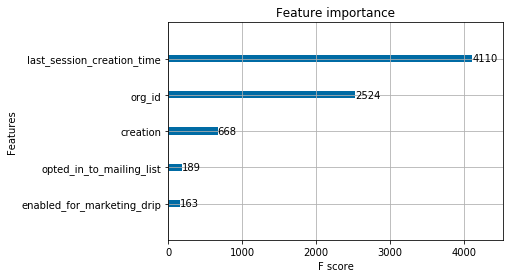

In [33]:
plot_importance(xg_clf_final)

In [41]:
# print active rate
active_user = df[df.active_status == 1]
inactive_user = df[df.active_status == 0]

active_rate = (len(active_user) / len(df)) * 100
active_rate
print("The resulting active rate of this service is:", active_rate)

The resulting active rate of this service is: 13.350000000000001


<div class="alert alert-warning">
<H1> Conclusions </H1>
<p>
The default parameters produced the best performing XGBoost model, resulting in a classification accuracy of 94.37% for the test data.  The factors that most heavily influence user adoption are the "last session creation time", and "org id" of influencers. This analysis was calculated looking at adopters who logged on to the system three days in a seven day window. The indicators were strong given the on-hand data suggesting that marketing efforts may want to be aimed at word of mouth campaigns and or other gorilla marketing tactics to influence influencers to recommend this offering.
</p>